<a href="https://colab.research.google.com/github/FlorianSong/MResAMS_DataAnalytics/blob/main/Workshop3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data analytics 2022

### Workshop 3 &ndash; Unsupervised Learning: Dimensionality reduction and Clustering &ndash; 10th November 2020
##### Taught by: Nan Wu, Wilson Wu, Florian Song, Linden Schrecker, Annabel Basford, Sophia Yaliraki

Much of today's workshop was taken from https://github.com/ageron/handson-ml2/ which in turn is based on the second edition of an O'Reilly book [Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) by Aurélien Geron.

Firstly, some house-keeping. We need to check if we have all the necessary libraries installed. For this we can use the following boiler plate code:

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os


import pandas as pd

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
mpl.rc('axes', labelsize = 14)
mpl.rc('xtick', labelsize = 12)
mpl.rc('ytick', labelsize = 12)

from sklearn.datasets import make_swiss_roll, load_iris, fetch_openml, make_blobs, load_wine, make_moons, fetch_olivetti_faces
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, silhouette_score, silhouette_samples
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, Isomap, MDS, LocallyLinearEmbedding
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

# Take-home challenge: Exploring the ChEMBL small molecule database

- This week, we will have a look at the data contained in the [ChEMBL](https://www.ebi.ac.uk/chembl/) database. 
- According to [Wikipedia](https://en.wikipedia.org/wiki/ChEMBL), ChEMBL or ChEMBLdb is a manually curated chemical database of bioactive molecules with drug-like properties. It is maintained by the European Bioinformatics Institute (EBI), of the European Molecular Biology Laboratory (EMBL), based at the Wellcome Trust Genome Campus, Hinxton, UK.
- Firstly, take some time to familiarise yourself with the database. To browse all compounds available, click [here](https://www.ebi.ac.uk/chembl/g/#browse/compounds). If you're unsure about how the various molecule properties are defined, you can have a look [here](https://www.dropbox.com/s/mixm4cn5x7azmg4/property_definitions.docx?dl=0).
- Next, download a csv file of all compounds with a molecular weight *less than 200*. This should keep the dataset reasonably small to do some exploratory analysis. In case you're having trouble doing that, you can also download the file [here](https://github.com/FlorianSong/MResAMS_DataAnalytics/blob/main/datasets/CHEMBL_200.csv).
- Finally, the rest of this challenge is completely open-ended! Play around with the data and see which variables make sense to focus on (all numeric variables or just some?). Try using dimensionality reduction to make the data more accessible to various models. What happens when you cluster the data? Can you find any trends in the clusters? 
- There is no correct answer here, but some are better than others.

Credit: Inspiration for this challenge was taken from [here](https://github.com/nebarlow/machine_learning_for_chem_bio). 

In [6]:
import pandas as pd
chembl = pd.read_csv('/Users/nan/Desktop/Digi_Chem_22_23/datasets/CHEMBL_200.csv', sep = ';')
# This is where I keep my csv file, you need to specify the path to your file!

# A selection of basic predictors
columns = ['Molecular Weight', 'Bioactivities', 'AlogP','PSA','HBA','HBD','#Rotatable Bonds', 'Heavy Atoms', 'Aromatic Rings']

chembl_subset = chembl[columns].dropna()
chembl_subset

,Molecular Weight,Bioactivities,AlogP,PSA,HBA,HBD,#Rotatable Bonds,Heavy Atoms,Aromatic Rings
4170,176.27,58.0,0.45,48.78,6.0,2.0,0.0,10.0,0.0
4171,178.23,1.0,1.99,35.01,3.0,0.0,4.0,13.0,1.0
4172,178.21,9.0,0.67,74.60,3.0,2.0,6.0,11.0,0.0
4173,137.16,2.0,-0.39,46.97,1.0,1.0,1.0,10.0,1.0
4174,164.16,33.0,0.27,55.02,4.0,0.0,1.0,12.0,1.0
...,...,...,...,...,...,...,...,...,...
34647,191.23,7.0,1.67,38.66,3.0,0.0,3.0,14.0,1.0
34648,181.20,3.0,-0.71,77.16,6.0,1.0,1.0,13.0,1.0
34649,190.25,1.0,1.66,23.55,2.0,0.0,1.0,14.0,1.0
34650,119.12,1.0,-1.22,83.55,3.0,3.0,2.0,8.0,0.0


In [7]:
chembl.dtypes

ChEMBL ID                           object
Name                                object
Synonyms                            object
Type                                object
Max Phase                            int64
Molecular Weight                   float64
Targets                              int64
Bioactivities                      float64
AlogP                              float64
PSA                                float64
HBA                                float64
HBD                                float64
#RO5 Violations                    float64
#Rotatable Bonds                   float64
Passes Ro3                          object
QED Weighted                       float64
ACD ApKa                           float64
ACD BpKa                           float64
ACD LogP                           float64
ACD LogD                           float64
Aromatic Rings                     float64
Structure Type                      object
Inorganic Flag                       int64
Heavy Atoms

In [8]:
X_subchembl = chembl_subset.to_numpy()

# PCA 
X_subchembl_scaled = StandardScaler().fit_transform(X_subchembl)
X_subchembl_pca = PCA(n_components = 0.9).fit_transform(X_subchembl_scaled)
X_subchembl_pca

array([[ 1.68738443,  0.43088688,  1.07584326,  0.1715543 ,  1.48873561,
         0.86795631],
       [-1.0503503 , -0.85466314, -1.21874964,  0.06097014,  0.93797514,
        -0.77258216],
       [ 1.57579282,  0.10540756, -2.60322136,  0.26505378,  0.07783195,
        -0.82332167],
       ...,
       [-1.71684939, -0.93686136,  0.01131534, -0.11318658,  0.41341939,
         0.8229923 ],
       [ 2.65515569,  2.77329787,  0.09535354, -0.32167196, -0.50510941,
        -0.39804064],
       [ 0.84595374,  1.65381068,  0.46603029, -0.27551031, -0.30882396,
        -1.12714253]])

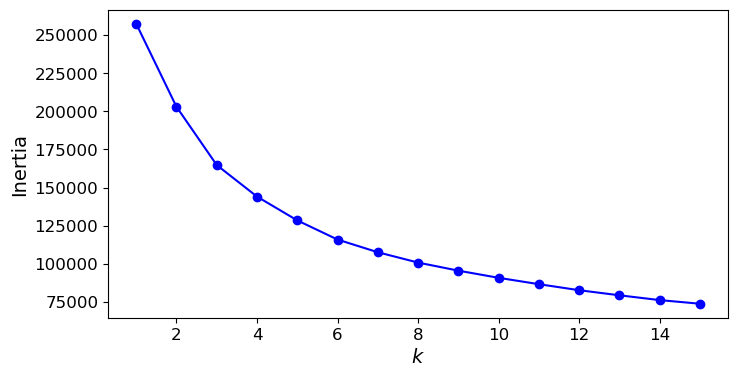

In [9]:
# KMeans
range_of_ks = range(1,16)
kmeans_per_k = [KMeans(n_clusters = k).fit(X_subchembl_pca) for k in range_of_ks]

inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize = (8, 4))
plt.plot(range_of_ks, inertias, 'bo-')
plt.xlabel('$k$', fontsize = 14)
plt.ylabel('Inertia', fontsize = 14)
plt.show()

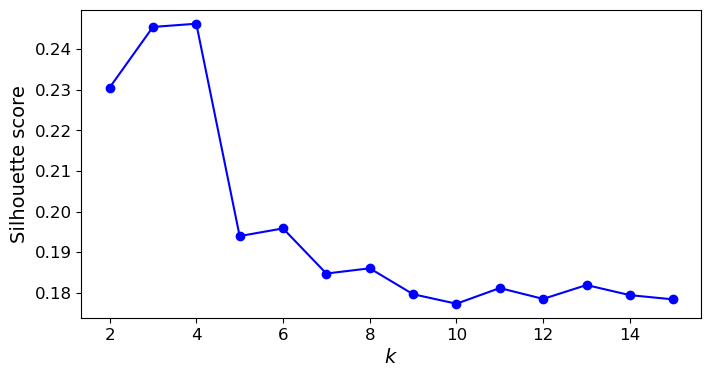

In [10]:
silhouette_scores = [silhouette_score(X_subchembl_pca, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize = (8, 4))
plt.plot(range_of_ks[1:], silhouette_scores, 'bo-')
plt.xlabel('$k$', fontsize = 14)
plt.ylabel('Silhouette score', fontsize = 14)
plt.show()

In [11]:
y_subchembl = KMeans(3).fit_predict(X_subchembl_pca)
y_subchembl

array([1, 0, 1, ..., 0, 1, 2], dtype=int32)

In [12]:
rndfor = RandomForestClassifier(n_estimators = 500)
rndfor.fit(X_subchembl, y_subchembl)

RandomForestClassifier(n_estimators=500)

In [13]:
for name, imp in zip(chembl_subset.columns, rndfor.feature_importances_):
    print(name.ljust(20), round(imp,2))

Molecular Weight     0.21
Bioactivities        0.01
AlogP                0.19
PSA                  0.25
HBA                  0.05
HBD                  0.06
#Rotatable Bonds     0.02
Heavy Atoms          0.17
Aromatic Rings       0.04


In [16]:
tsne = TSNE().fit_transform(X_subchembl_pca)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


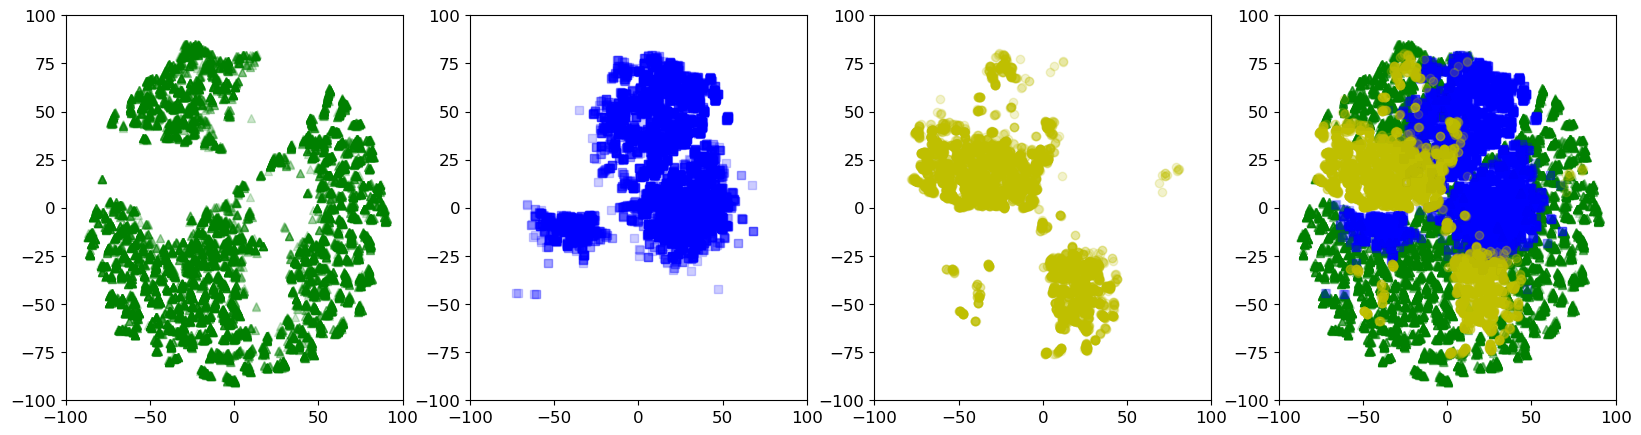

In [17]:
plt.figure(figsize = (20,5))

plt.subplot(141)
plt.plot(tsne[:,0][y_subchembl == 0], tsne[:,1][y_subchembl == 0], 'g^', alpha = 0.2)
plt.axis([-100, 100, -100, 100])

plt.subplot(142)
plt.plot(tsne[:,0][y_subchembl == 1], tsne[:,1][y_subchembl == 1], 'bs', alpha = 0.2)
plt.axis([-100, 100, -100, 100])

plt.subplot(143)
plt.plot(tsne[:,0][y_subchembl == 2], tsne[:,1][y_subchembl == 2], 'yo', alpha = 0.2)
plt.axis([-100, 100, -100, 100])

plt.subplot(144)
plt.plot(tsne[:,0][y_subchembl == 0], tsne[:,1][y_subchembl == 0], 'g^', alpha = 0.2)
plt.plot(tsne[:,0][y_subchembl == 1], tsne[:,1][y_subchembl == 1], 'bs', alpha = 0.2)
plt.plot(tsne[:,0][y_subchembl == 2], tsne[:,1][y_subchembl == 2], 'yo', alpha = 0.2)
plt.axis([-100, 100, -100, 100])

plt.show()